# Predicting Car Prices like a Baws

In this project, I'm going to predict a car's market price using its attributes. The data set that will be used contains information on various cars and for each car we have info about the technical aspects of the vehicle such as the motor's displacement, weight of the car, miles per gallon, how fast the care accelerates, and how likely the car will be in a fast & furious movie (just kidding). You can read more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/automobile) if you'd like. 

Let's read in the dataset.

In [1]:
import pandas as pd
import numpy as np

cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars = pd.read_csv('imports-85.data', names=cols)

pd.options.display.max_columns = 99

In [2]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


Now taking a look at the columns, we already know that the price column will the target column for making predictions. 

The numeric columns that we'll use as features will be all columns with continuous values based on the info we can see on the dataset.

In [3]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

numeric_cars = cars[continuous_values_cols]

# Null values and column types

There are some ? values in the normalized-losses column that we should replace with the numpy.nan missing value. We'll also convert all column types to int types. 

In [4]:
numeric_cars = numeric_cars.replace('?', np.nan)

numeric_cars.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


In [5]:
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [6]:
# since price is the target column, let's remove rows with no value for that column
numeric_cars = numeric_cars.dropna(subset=['price'])

In [7]:
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [8]:
# We're going to take a risk and fill all null values with the mean from that column
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [9]:
# Let's quickly confirm we don't have any more null values
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [10]:
# Now let's normalize the numeric columns so all values range from 0 to 1
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())

In [11]:
numeric_cars['price'] = price_col

### Univariate k-nearest neighbors models

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_column, target_column, df):
    # instantiate KNeighborsRegressor class
    knn = KNeighborsRegressor()
    np.random.seed(1)
    
    # randomize order of the dataset
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    # divide number of rows in half and round
    last_train_row = int(len(rand_df) / 2)
    
    # create train and test sets
    train = rand_df.iloc[0:last_train_row]
    test = rand_df.iloc[last_train_row:]
    knn.fit(train[[train_column]], train[target_column])
    predictions = knn.predict(test[[train_column]])
    
    # find rmse value
    mse = mean_squared_error(test[target_column], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

# for every column in train_cols, train a model, return RMSE value and add to dictionary
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val
    
# create a series object from the dictionary to easily view results

rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

In [13]:
def knn_train_test_k(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test_k(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 8602.58848450066,
  3: 6984.239489480916,
  5: 6780.627784685976,
  7: 6878.097965921532,
  9: 6866.808502038413},
 'city-mpg': {1: 5901.143574354764,
  3: 4646.746408727155,
  5: 4766.422505090134,
  7: 5232.523034167316,
  9: 5465.209492527533},
 'compression-rate': {1: 8087.205346523092,
  3: 7375.063685578359,
  5: 6610.812153159129,
  7: 6732.801282941515,
  9: 7024.485525463435},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'engine-size': {1: 3258.4861059962027,
  3: 2840.562805643501,
  5: 3238.4628296477176,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'highway-mpg': {1: 6025.594966720739,
  3: 4617.305019788554,
  5: 4630.026798588056,
  7: 4796.061440186946,
  9: 5278.358056953987},
 'horsepower': {1: 4170.054848037801,
  3: 4020.8492630885

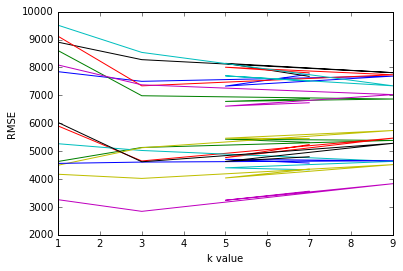

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

### Multivariate Model

In [21]:
# Computer average RMSE value across all features
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse

# convert to series to be more readable
feature_avg_rmse_series = pd.Series(feature_avg_rmse)
sorted_avg_rmse = feature_avg_rmse_series.sort_values()

sorted_features = sorted_avg_rmse.index

In [27]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {5: 2949.8817277180374},
 '3 best features': {5: 3580.7376651928435},
 '4 best features': {5: 3487.340917327035},
 '5 best features': {5: 3410.2170133901805},
 '6 best features': {5: 3478.510890118539}}

### Optimizing the best performing models through hyperparameter variation

In [28]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = range(1,26)
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}
cols = [2, 5, 6]
for nr_best_feats in cols:
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {1: 2783.6204237227344,
  2: 2657.7963807419765,
  3: 2792.586573031673,
  4: 2891.5329686923255,
  5: 2949.8817277180374,
  6: 3096.402601694776,
  7: 3164.681969020496,
  8: 3413.228359192009,
  9: 3748.6716603306486,
  10: 4080.7125057341937,
  11: 4215.6372280600335,
  12: 4275.421524277872,
  13: 4373.901683035496,
  14: 4424.285137239815,
  15: 4539.505493095937,
  16: 4667.307671446768,
  17: 4729.605305844226,
  18: 4790.556632159094,
  19: 4824.3866193292615,
  20: 4840.850914693829,
  21: 4837.429062000271,
  22: 4831.16988267597,
  23: 4861.679492959275,
  24: 4903.346008862579,
  25: 4955.892429427362},
 '5 best features': {1: 2824.7061233282866,
  2: 2915.6731645496975,
  3: 3012.4204546509704,
  4: 3202.8876051367483,
  5: 3410.2170133901805,
  6: 3618.4509432660384,
  7: 3622.6290209234803,
  8: 3848.635835654326,
  9: 3977.8149139381726,
  10: 3994.8132211260104,
  11: 4159.843526607947,
  12: 4294.3389473154875,
  13: 4380.848359486949,
  14: 4466.3

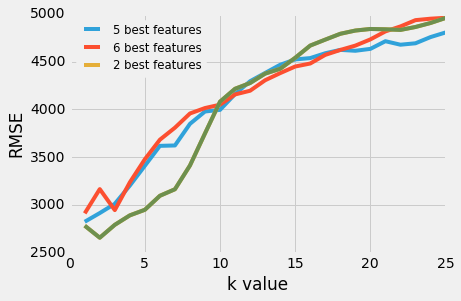

In [38]:
plt.style.use('fivethirtyeight')
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x,y, label="{}".format(k))
    
plt.plot(x,y)
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend(loc='upper left', fontsize='small')
    

Based on this last model, it seems that 2 best features is the best option (except we can't be sure because for some reason this plot is showing the wrong colours corresponding to the line for 2 best features). Here are the final best k values:

- 2 best features: k = 2
- 5